<a href="https://colab.research.google.com/github/FabioPojo1987/FabioPojo1987-MVP_2_DATA_SCIENCE_PUC_RIO/blob/main/MVP_2_DATA_SCIENCE_PUC_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto da 2ª Sprint do curso de Ciência de Dados na PUC Rio

Este projeto se trata de um aprendizado de máquina para criar insights sobre a variação da taxa de Câmbio entre o Dólar Americano USD e o Real Brasileiro BRL em um determinado período de tempo entre o passado e o presente.

Neste projeto, irá ser utilizado a biblioteca que o Yahoo Finance disponibiliza para uso no Python, o "yfinance library" para podermos adquirir as informações necessárias do histórico do Banco de Dados do Yahoo Finance.

[*********************100%%**********************]  1 of 1 completed


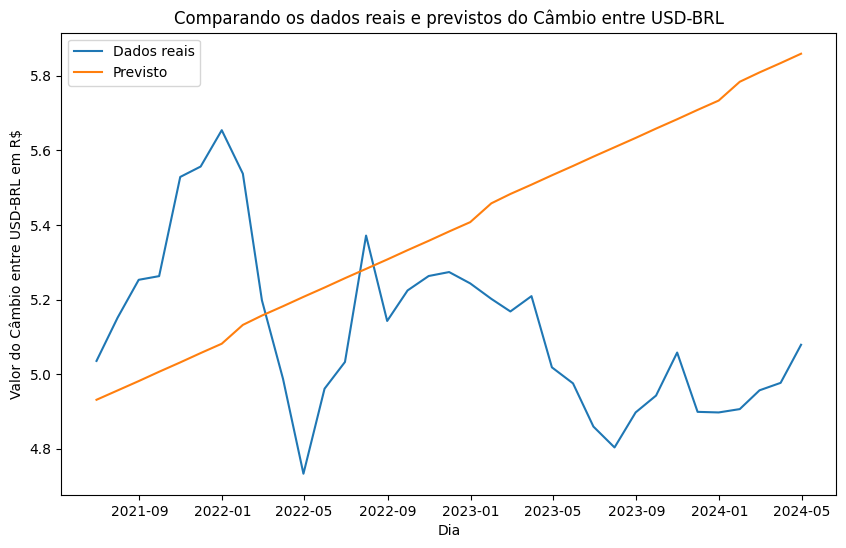

In [64]:
# Passo 1: Instalar as bibliotecas necessárias (se já não tiver instalado antes)
# !pip install pandas matplotlib yfinance scikit-learn

# Passo 2: Importar as bibliotecas abaixo
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Passo 3: Buscar os dados históricos de câmbio do yfinance (Yahoo Finance)
start_date = '2010-01-01'
end_date = '2024-04-30'
data = yf.download('USDBRL=X', start=start_date, end=end_date)

# Passo 4: Preprocessando os dados
data = data['Close'].resample('M').mean().ffill()

# Passo 5: Dividindo os dados em Conjuntos de Treinamento e Teste
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Passo 6: Treinando um modelo de machine learning
X_train = pd.DataFrame(index=train_data.index)
X_train['month'] = train_data.index.month
X_train['year'] = train_data.index.year
y_train = train_data.values

model = LinearRegression()
model.fit(X_train, y_train)

# Passo 7: Definindo parâmetros de previsões para o conjunto de teste
X_test = pd.DataFrame(index=test_data.index)
X_test['month'] = test_data.index.month
X_test['year'] = test_data.index.year
y_test = test_data.values
predictions = model.predict(X_test)

# Passo 8: Visualizar os resultados
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Dados reais')
plt.plot(test_data.index, predictions, label='Previsto')
plt.xlabel('Dia')
plt.ylabel('Valor do Câmbio entre USD-BRL em R$')
plt.title('Comparando os dados reais e previstos do Câmbio entre USD-BRL')
plt.legend()
plt.show()


Ao observar os gráficos, é possível perceber a variação na taxa de câmbio entre o Real Brasileiro (BRL-R$) e o Dólar Americano (USD) no período da Pandemia da Covid-19 (2020 a 2022) e o período de retomada da economia no Pós Pandemia (2022 até o presente momento). Ao comparar com o que era previsto à época da pandemia, podemos observar a enorme diferença na taxa de câmbio.

O que mostra como a AI pode ser uma boa ferramenta para analisar e planejar medidas no sentido da economia nacional a fim de elaborar novas formas de melhorias na taxa de câmbio